# TATA Box Project

The goal of this notebook is to build a classifier that distinguishes
between random DNA sequences and "promoter-like" sequences containing a TATA box.

I explore the following ideas in this project :
- Baseline: regex search for a TATA box.
- Model: k-mer counts + Logistic Regression.
- Extra touch: a position feature (TATA should appear in a specific window).


In [1]:
# Setup and data generation

import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

random.seed(42)
np.random.seed(42)

ALPH = "ACGT"
MOTIF = "TATAAA"
L = 100       # sequence length
N = 2000      # dataset size

def random_seq(L=100):
    return "".join(random.choice(ALPH) for _ in range(L))

def implant_motif(seq, motif=MOTIF, p_noise=0.15):
    """Implant motif with some mutations (p_noise per base)."""
    pos = random.randint(0, L - len(motif))
    seq = list(seq)
    for i, ch in enumerate(motif):
        if random.random() < p_noise:
            seq[pos+i] = random.choice([b for b in ALPH if b != ch])
        else:
            seq[pos+i] = ch
    return "".join(seq)

# dataset creation

X, y = [], []

# Positives: random seq + implanted motif with some noise
for _ in range(N//2):
    s = implant_motif(random_seq(), p_noise=0.15)
    X.append(s); y.append(1)

# Negatives: random seq, some with heavily mutated motif
for _ in range(N//2):
    s = random_seq()
    if random.random() < 0.2:
        s = implant_motif(s, p_noise=0.8)
    X.append(s); y.append(0)

X = np.array(X)
y = np.array(y)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


### Baseline: simple motif search
We classify as positive if the exact TATAAA motif is present with ≤1 mismatch.


In [2]:
# Baseline Regex

def contains_with_mismatches(seq, motif=MOTIF, max_mm=1):
    m = len(motif)
    for i in range(len(seq)-m+1):
        window = seq[i:i+m]
        mm = sum(a!=b for a,b in zip(window, motif))
        if mm <= max_mm:
            return True
    return False

baseline_pred = np.array([contains_with_mismatches(s) for s in Xte], dtype=int)
baseline_proba = baseline_pred.astype(float)

print("Baseline Accuracy:", accuracy_score(yte, baseline_pred))
print("Baseline F1:", f1_score(yte, baseline_pred))
print("Baseline ROC-AUC:", roc_auc_score(yte, baseline_proba))
print("Baseline PR-AUC:", average_precision_score(yte, baseline_proba))


Baseline Accuracy: 0.7375
Baseline F1: 0.7640449438202247
Baseline ROC-AUC: 0.7375
Baseline PR-AUC: 0.6647959183673469


### Model: k-mers + Logistic Regression
We use character n-grams (3 to 6-mers) as features.  
We also add a binary feature: is "TATA" present in a specific window (positions 25–40)

---




In [3]:
from scipy.sparse import hstack, csr_matrix

def has_tata_in_window(seq, sub="TATA", win=(25,40)):
    i,j = win
    return int(sub in seq[i:j])

vec = CountVectorizer(analyzer="char", ngram_range=(3,6))
Xtr_k = vec.fit_transform(Xtr)
Xte_k = vec.transform(Xte)

win_tr = np.array([has_tata_in_window(s) for s in Xtr]).reshape(-1,1)
win_te = np.array([has_tata_in_window(s) for s in Xte]).reshape(-1,1)

Xtr_all = hstack([Xtr_k, csr_matrix(win_tr)])
Xte_all = hstack([Xte_k, csr_matrix(win_te)])

clf = LogisticRegression(max_iter=5000)
clf.fit(Xtr_all, ytr)

proba = clf.predict_proba(Xte_all)[:,1]
yhat = clf.predict(Xte_all)


### Results



In [4]:
print("LogReg Accuracy:", accuracy_score(yte, yhat))
print("LogReg F1:", f1_score(yte, yhat))
print("LogReg ROC-AUC:", roc_auc_score(yte, proba))
print("LogReg PR-AUC:", average_precision_score(yte, proba))


LogReg Accuracy: 0.665
LogReg F1: 0.6666666666666666
LogReg ROC-AUC: 0.718125
LogReg PR-AUC: 0.7333067247722098


### ROC curve plot

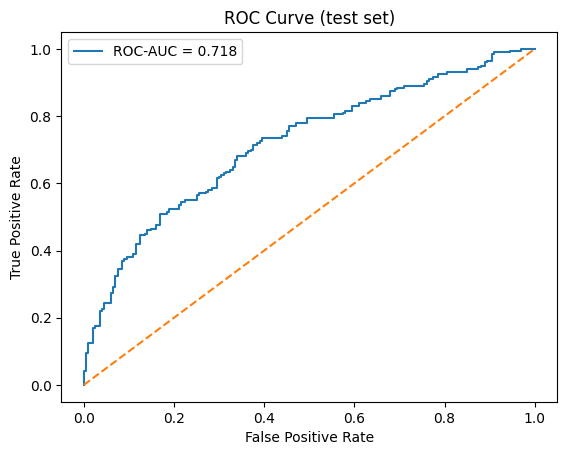

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(yte, proba)
auc = roc_auc_score(yte, proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (test set)")
plt.legend()
plt.show()


### Precision–Recall Curve plot

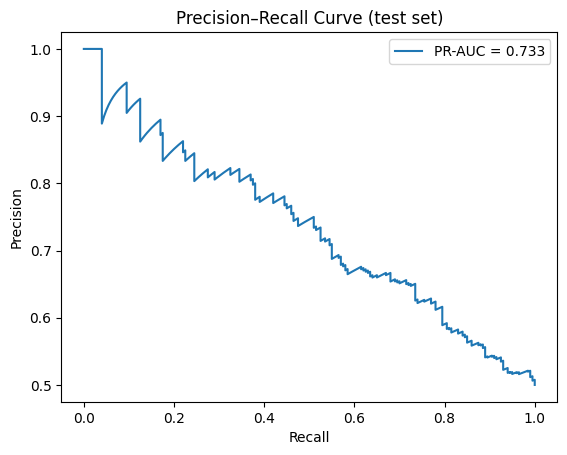

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(yte, proba)
ap = average_precision_score(yte, proba)

plt.figure()
plt.plot(rec, prec, label=f"PR-AUC = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (test set)")
plt.legend()
plt.show()


### Interpreting top k-mers

In [7]:
# Map back features
vocab = [None] * len(vec.vocabulary_)
for kmer, idx in vec.vocabulary_.items():
    vocab[idx] = kmer

coef_all = clf.coef_.ravel()
coef_k = coef_all[:-1]   # last one = window feature
coef_win = coef_all[-1]

top_idx = np.argsort(-coef_k)[:10]
print("Window feature weight:", coef_win)
print("\nTop k-mers (pro-promoter):")
for i in top_idx:
    print(f"{vocab[i]:<6} {coef_k[i]:+.3f}")


Window feature weight: 0.3707462580455534

Top k-mers (pro-promoter):
tataaa +1.861
tataa  +1.001
ataaa  +0.948
tataga +0.548
atgaat +0.538
tatgaa +0.522
gttata +0.510
taatac +0.506
taaa   +0.503
ttatcc +0.489


### Demo

In [8]:
demo = [
    implant_motif(random_seq(), p_noise=0.0),  # perfect motif
    implant_motif(random_seq(), p_noise=0.3),  # noisy motif
    random_seq()                               # random
]

demo_k = vec.transform(demo)
demo_win = np.array([has_tata_in_window(s) for s in demo]).reshape(-1,1)
demo_all = hstack([demo_k, csr_matrix(demo_win)])

print("Demo predictions (proba promoter-like):")
for s,p in zip(demo, clf.predict_proba(demo_all)[:,1]):
    print(f"p={p:.3f}, contains_exact_TATA={MOTIF in s}")


Demo predictions (proba promoter-like):
p=1.000, contains_exact_TATA=True
p=0.937, contains_exact_TATA=False
p=0.001, contains_exact_TATA=False


### Conclusion

This project shows how:
- A regex baseline already works if the motif is exact.
- Logistic Regression with k-mers can capture *variants* of the motif.
- A simple positional feature improves realism: in biology, promoter motifs
  usually occur at specific locations.

While this project is basic compared to other existing models (e.g Instadeep's Nucleotide Transformers) models, it reflects a motivation to explore AI
applied to genomics and to learn step by step.
